In [4]:
# Import packages
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib import image

In [6]:
# Import packages

# Data analysis
import numpy as np
import pandas as pd

# File management
import os
import shutil

# Image visualisation
import matplotlib.pyplot as plt

# Neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
# If TPU is available
try:
    # Detect TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())

except:
    tpu = None
    

# If TPU is defined
if tpu:
    # Initialise TPU
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # Instantiate a TPU distribution strategy
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

else:
    # Or instanstiate available strategy
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2023-12-25 20:07:20.665374: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-25 20:07:20.665483: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-25 20:07:20.665603: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-25 20:07:20.665688: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-25 20:07:20.665763: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-25 20:07:20.665950: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-25 20:07:20.666039: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS:  8


In [8]:
# Define constants

# Set batch size for mini-batch gradient descent
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
# Set number of epochs to train model
EPOCH_NUM = 50

# Set kernel size for Conv2D layers
KERNEL_SIZE = 3
# Set padding mode for Conv2D layers
PAD_MODE = "same"
# Set activation function for Conv2D layers
ACTIVATION = "relu"

# Set pool size for MaxPool2D layers
POOL_SIZE = 2
# Set strides for MaxPool2D layers
POOL_STRIDES = 2

In [9]:
# Store paths to base, train set and subset dirs
base_dir = "/kaggle/input/imagenet-object-localization-challenge/"
data_dir = base_dir + "ILSVRC/Data/CLS-LOC/"

# Fetch train set
raw_train_ds = tf.data.Dataset.list_files(data_dir + "train/n01*/*.JPEG", shuffle=False)

# Find size of train set
train_size = tf.data.experimental.cardinality(raw_train_ds).numpy()

# Shuffle train set
raw_train_ds = raw_train_ds.shuffle(train_size, reshuffle_each_iteration=False)

print(f"Size of train set: {train_size}")

Size of train set: 164467


In [10]:
# Import and extract devel labels
devel_df = pd.read_csv(base_dir + "LOC_val_solution.csv")
y_devel = devel_df["PredictionString"].str.split(expand=True)[0]

# Select devel images belonging to subset of classes
keep = np.where(y_devel.str.startswith("n01").to_numpy())[0]
devel_files = np.array(os.listdir(data_dir + "val/"))[keep]

# Fetch devel set
devel_files = np.array([data_dir + "val/" + file for file in devel_files])
raw_devel_ds = tf.data.Dataset.list_files(devel_files, shuffle=False)

# Select labels belonging to subset of classes
y_devel = y_devel[y_devel.str.startswith("n01")].values

# Find size of devel set
devel_size = tf.data.experimental.cardinality(raw_devel_ds).numpy()

print(f"Size of train set: {devel_size}")
print("Examples of labels:")
y_devel[:10]

Size of train set: 6350
Examples of labels:


array(['n01514859', 'n01950731', 'n01910747', 'n01632458', 'n01806143',
       'n01817953', 'n01698640', 'n01669191', 'n01491361', 'n01828970'],
      dtype=object)

In [11]:
# Find class names from dir names
class_names = np.array(sorted([dir for dir in os.listdir(data_dir + "train/") if dir.startswith("n01")]))

# Set number of classes
CLASS_NUM = len(class_names)

for f in raw_train_ds.take(5):
    print(f.numpy())

b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01753488/n01753488_26406.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01669191/n01669191_1970.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01667114/n01667114_6173.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01491361/n01491361_6285.JPEG'
b'/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train/n01807496/n01807496_27876.JPEG'


tf.Tensor(8, shape=(), dtype=int64)


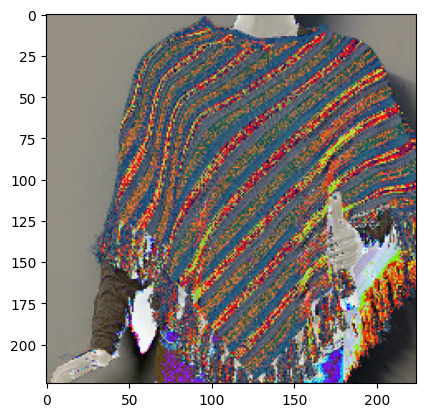

In [12]:
# Define label extractor for train samples
def extract_train_label(file_path):
    
    # Split file path into parts
    parts = tf.strings.split(file_path, os.path.sep)
    # Extract class dir name
    one_hot = parts[-2] == class_names
    # Find index of maximum
    label = tf.argmax(one_hot)
    
    return label

# Define label extractor for devel samples
def extract_devel_label(file_path):
    
    # One-hot encode indices
    idx_hot = devel_files == file_path
    # Find index
    idx = tf.argmax(idx_hot)
    # Extract class name
    class_name = tf.gather(y_devel, idx)

    # Extract class dir name
    one_hot = class_name == class_names
    # Find index of maximum
    label = tf.argmax(one_hot)
    
    return label

# Define sample preprocessing pipeline
def process_path(file_path, label_fun=extract_train_label, cut=224, S=256, max_delta=0.2):
    
    # Convert the compressed string to a 3D uint8 tensor
    image = tf.io.read_file(file_path)
    image = tf.io.decode_jpeg(image, channels=3)
    
    image =  tf.keras.applications.vgg16.preprocess_input(image)
   
    # Find rescaling factor
    min_side = tf.math.minimum(tf.shape(image)[0], tf.shape(image)[1])
    scale = S / min_side

    # Compute new dimensions
    new_height = tf.cast(tf.shape(image)[0], tf.float64) * scale
    new_width = tf.cast(tf.shape(image)[1], tf.float64) * scale
    
    # Convert to float
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Rescale by S
    image = tf.image.resize(image, size=(new_height, new_width), preserve_aspect_ratio=True)
    # Crop randomly
    image = tf.image.random_crop(image, size=[cut, cut, 3])
    # adjust RGB values by random amount
    image = tf.image.random_hue(image, max_delta=max_delta)
    
    label = label_fun(file_path)
    
    return image, label

image, label = process_path(data_dir + "val/ILSVRC2012_val_00046886.JPEG", label_fun=extract_devel_label)
input_shape = image.shape

plt.imshow(image)
print(label)

In [19]:
image.shape

TensorShape([224, 224, 3])

In [13]:
# Preprocess images
train_ds = raw_train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
devel_ds = raw_devel_ds.map(lambda path: process_path(path, label_fun=extract_devel_label, max_delta=0), num_parallel_calls=tf.data.AUTOTUNE)

# Show example
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())


Image shape:  (224, 224, 3)
Label:  66


In [14]:
# Improve train set performance
train_ds = train_ds \
    .cache() \
    .shuffle(buffer_size=1000) \
    .batch(BATCH_SIZE) \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

# Improve devel set performance
devel_ds = devel_ds \
    .batch(BATCH_SIZE) \
    .cache() \
    .prefetch(buffer_size=tf.data.AUTOTUNE)

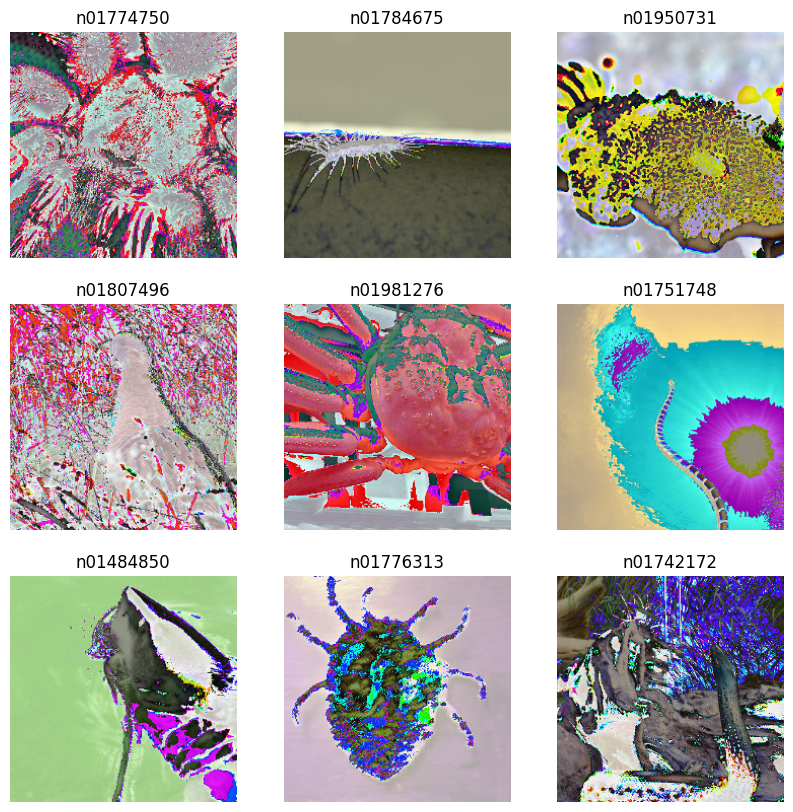

In [15]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i])
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [17]:
# Build model
def design_model():
    
    model = keras.models.Sequential([

        # 1st convolutional block
        layers.Conv2D(input_shape=input_shape, filters=64, kernel_size=KERNEL_SIZE,  kernel_initializer=initializers.RandomNormal(stddev=0.1), padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # 2nd convolutional block
        layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE,  kernel_initializer=initializers.RandomNormal(stddev=0.1), padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # 3rd convolutional block
        layers.Conv2D(filters=256, kernel_size=KERNEL_SIZE,  kernel_initializer=initializers.RandomNormal(stddev=0.1), padding=PAD_MODE, activation=ACTIVATION),
        layers.Conv2D(filters=256, kernel_size=KERNEL_SIZE,  kernel_initializer=initializers.RandomNormal(stddev=0.1), padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # 4th convolutional block
        layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE,  kernel_initializer=initializers.RandomNormal(stddev=0.1), padding=PAD_MODE, activation=ACTIVATION),
        layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, kernel_initializer=initializers.RandomNormal(stddev=0.1), padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # 5th convolutional block
        layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE, kernel_initializer=initializers.RandomNormal(stddev=0.1), padding=PAD_MODE, activation=ACTIVATION),
        layers.Conv2D(filters=512, kernel_size=KERNEL_SIZE,  kernel_initializer=initializers.RandomNormal(stddev=0.1), padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # Classifier head
        layers.Flatten(),
        layers.Dense(4096, activation=ACTIVATION, kernel_initializer=initializers.RandomNormal(stddev=0.1)),
        layers.Dropout(rate=0.5),
        layers.Dense(4096, activation=ACTIVATION, kernel_initializer=initializers.RandomNormal(stddev=0.1)),
        layers.Dropout(rate=0.5),
        layers.Dense(CLASS_NUM, kernel_initializer=initializers.RandomNormal(stddev=0.1))
    ])
    
    return model



#std of ten to the minus 2 , random initailization in 11 layers should be in ALL layers 

In [18]:
def create_optimiser():
    
    sgd_optimiser = keras.optimizers.experimental.SGD(
            learning_rate=1e-2,
            momentum=0.9,
            nesterov=False,
            weight_decay=5e-4
        )
    
    return sgd_optimiser

In [19]:
# Set up model within scope of tpu strategy
with strategy.scope():
    
    # Build model
    model = design_model()
    
    # Define optimiser
    sgd_optimiser = create_optimiser()
    
    # Compile model
    model.compile(
        optimizer = sgd_optimiser,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["sparse_categorical_accuracy"]
    )

2023-12-25 20:08:41.118982: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-25 20:08:41.119127: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


In [20]:
model.get_weights() #sanity check, 0s are biases that are initialized to 0 automatically by keras

[array([[[[-0.09806814,  0.02894443, -0.00421731, ..., -0.05056686,
            0.05549648, -0.07774836],
          [ 0.02695513, -0.1595283 ,  0.04598783, ..., -0.07479539,
           -0.07988396,  0.04373315],
          [ 0.1470196 , -0.17969185, -0.09195445, ...,  0.14692321,
            0.01983687, -0.06083285]],
 
         [[-0.08771574, -0.15839437,  0.13169277, ...,  0.0527064 ,
           -0.00336734, -0.08310006],
          [ 0.13799559,  0.00840771, -0.14424318, ..., -0.12358731,
           -0.07777705,  0.10671826],
          [ 0.08873866,  0.12598537, -0.02961538, ...,  0.05571067,
            0.01106717,  0.07791873]],
 
         [[-0.12977138,  0.03416797, -0.0699553 , ...,  0.06857065,
            0.06561439, -0.06711283],
          [ 0.07918006,  0.04609183, -0.05419296, ..., -0.00832093,
            0.11461258,  0.15585902],
          [ 0.0035975 ,  0.02170295,  0.07705732, ...,  0.07956233,
           -0.0094227 , -0.13493507]]],
 
 
        [[[ 0.06229351, -0.0479556

In [ ]:
# Update learning rate
LR_Decay = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode="min",
    min_delta=1e-4,
    min_lr=1e-5
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=devel_ds,
    epochs=EPOCH_NUM,
    batch_size=BATCH_SIZE,
    verbose=False,
    callbacks=[LR_Decay]
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}, Devel loss: {history_df['val_loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['sparse_categorical_accuracy'].iloc[-1]:.3f}, Devel accuracy: {history_df['val_sparse_categorical_accuracy'].iloc[-1]:.3f}")

2023-12-25 20:10:41.233443: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-25 20:10:41.251703: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-25 20:10:41.269522: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-25 20:10:41.287723: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-25 20:10:41.306029: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-25 20:10:41.324285: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-25 20:10:41.342592: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

In [ ]:
# Visualise loss
history_df.loc[:, ["loss", "val_loss"]].plot(title="Loss")

In [ ]:
# Visualise accuracy
history_df.loc[:, ["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot(title="Accuracy")

#Transfer Learning

The next step involves building a deeper ConvNet by:

taking the pretrained base from the previous section,
enriching it with new untrained convolutional layers and
attaching it to a new untrained classification head
By transferring the learnt weight from our previous model, we can build more complex and deeper ConvNets without too much computational burden. In particular, here we aim to reproduce the following four architectures from Zimonyan & Zisserman 2015:

13-layer ConvNet
16-layer ConvNet (with 1-by-1 filters)
16-layer ConvNet (with 3-by-3 filters)
19-layer ConvNet
In the following cell, we pretend that the previously trained model is stored in a keras file to show how pretrained models can be imported into a notebook.

In [ ]:
# Define model file
model_file = f"/kaggle/working/{CLASS_NUM}class_model.keras"

# Save model into file for replication purposes
model.save(model_file)

In [ ]:
# Build model
def design_model(model_file, layer_positions=[0, 2, 4, 5, 7, 8, 10, 11]): #CHANGE: transfer specific layers as per architecture
    
    # Import pretrained base
    pretrained_base = keras.models.load_model(model_file)
    
    # Select relevant layers
    pretrained_layers = [pretrained_base.get_layer(index=i) for i in layer_positions]
    
    model = keras.models.Sequential([

        # 1st convolutional block
        pretrained_layers[0],
        layers.Conv2D(filters=64, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # 2nd convolutional block
        pretrained_layers[1],
        layers.Conv2D(filters=128, kernel_size=KERNEL_SIZE, padding=PAD_MODE, activation=ACTIVATION),
        layers.MaxPooling2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # 3rd convolutional block
        pretrained_layers[2],
        pretrained_layers[3],
        layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # 4th convolutional block
        pretrained_layers[4],
        pretrained_layers[5],
        layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # 5th convolutional block
        pretrained_layers[6],
        pretrained_layers[7],
        layers.MaxPool2D(pool_size=POOL_SIZE, strides=POOL_STRIDES),

        # Classifier head
        layers.Flatten(),
        layers.Dense(4096, activation=ACTIVATION),
        layers.Dropout(rate=0.5),
        layers.Dense(4096, activation=ACTIVATION),
        layers.Dropout(rate=0.5),
        layers.Dense(CLASS_NUM)
    ])
    
    return model

In [ ]:
# Set up model within scope of tpu strategy
with strategy.scope():
    
    # Build model
    model = design_model(model_file)
    
    # Define optimiser
    sgd_optimiser = create_optimiser()
    
    # Compile model
    model.compile(
        optimizer = sgd_optimiser,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["sparse_categorical_accuracy"]
    )

In [ ]:
# Update learning rate
LR_Decay = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=2,
    mode="min",
    min_delta=1e-4,
    min_lr=1e-5
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=devel_ds,
    epochs=70 - EPOCH_NUM,
    batch_size=BATCH_SIZE,
    verbose=False,
    callbacks=[LR_Decay]
)

# Store training history as a dataframe
history_df = pd.DataFrame(history.history)

print(f"Train loss: {history_df['loss'].iloc[-1]:.3f}, Devel loss: {history_df['val_loss'].iloc[-1]:.3f}")
print(f"Train accuracy: {history_df['sparse_categorical_accuracy'].iloc[-1]:.3f}, Devel accuracy: {history_df['val_sparse_categorical_accuracy'].iloc[-1]:.3f}")

In [ ]:
# Visualise loss
history_df.loc[:, ["loss", "val_loss"]].plot(title="Loss")

In [ ]:
# Visualise accuracy
history_df.loc[:, ["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot(title="Accuracy")